In [1]:
import Data_acq as data
from models import Encoder
from models import Decoder
from models import cVAE
import matplotlib.pyplot as plt
import importlib

Datos

In [2]:
import importlib
importlib.reload(data)
x_train, x_test,x_val ,y_train, y_test,y_val, x_train_1, y_train_1 = data.get_mnist_data()




Enconder decoder


(1, 784)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[-0.14565653 -0.57976705 -0.34509587 -0.20294397  0.11750933  0.05253248
   0.17541729 -0.03401375 -0.615047    0.07909947  0.01850466 -0.42403677
   0.1577286   0.18488652 -0.0582096  -0.12124447 -0.5520807   0.64778847
  -0.19525065  0.15727869  0.04566885 -0.09702379 -0.0014953  -0.47372568
   0.5231614   0.12887591  0.10435654 -0.09453908  0.07250896  0.09203476
  -0.83237135 -0.47820243  0.48221043  0.07114301  0.22135554  0.17638117
  -0.24630617  0.21427113 -0.16034769 -0.13754737 -0.05957664  0.03641937
   0.42943132  0.09335715  0.40589586  0.19950199  0.01245199  0.6354642
  -0.19190823 -0.5708149  -0.4314006   0.3957066  -0.12218273 -0.05419888
   0.16436502 -0.36659226  0.10761999  0.42571914 -0.17061348  0.28291813
   0.50627995 -0.24004589 -0.17909846  0.5125592 ]]
[[-0.04518946 -0.16099001 -0.02114092 -0.1883325   0.18355949  0.03358299
   0.7386909   0.64718217 -0.11536667  0.2192602

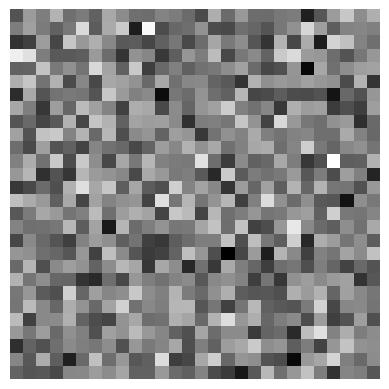

In [ ]:
import importlib
import numpy as np
importlib.reload(Encoder)
importlib.reload(Decoder)

#img_dim=(28,28),condition_dim=(10,),intermediate_dim=128,latent_dim=2
#latent_dim=2, cond_dim=(10,), intermediate_dim=128, original_shape=(28, 28)

en = Encoder.build_enconder(intermediate_dim=128,latent_dim=64)
de = Decoder.build_decoder(intermediate_dim=128,latent_dim=64)


img_sample = np.expand_dims(x_train[0], axis=0)# shape (1, 28, 28)
cond_sample = np.expand_dims(y_train[0], axis=0) 
print(img_sample.shape)
[z, z_mean, z_log_var] = en.predict([img_sample,cond_sample])

img_recons = de.predict([z,cond_sample])

print(z)
print(z_mean)
print(z_log_var)
print(img_recons[0].shape)

plt.imshow(img_recons[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()


In [4]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

importlib.reload(cVAE)
original_dim = 28*28
beta = 1.0

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), x_train))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset = train_dataset.batch(128)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), x_val))
val_dataset = val_dataset.batch(128)


cvae = cVAE.CVAE(encoder=en, decoder=de, original_dim=original_dim, beta=1)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

cvae.fit(train_dataset,
        epochs=10,
        batch_size=128,
        validation_data=val_dataset,
        callbacks=[early_stopping]
         )

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - kl_loss: 3.6720 - loss: 71.8413 - reconstruction_loss: 68.1693 - val_kl_loss: 4.8165 - val_loss: 42.2234 - val_reconstruction_loss: 37.5004
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 5.1641 - loss: 41.1753 - reconstruction_loss: 36.0112 - val_kl_loss: 5.5391 - val_loss: 37.2927 - val_reconstruction_loss: 31.8033
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.7402 - loss: 36.9597 - reconstruction_loss: 31.2195 - val_kl_loss: 5.8294 - val_loss: 34.6061 - val_reconstruction_loss: 28.8452
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 6.1186 - loss: 34.6115 - reconstruction_loss: 28.4929 - val_kl_loss: 6.3850 - val_loss: 33.2634 - val_reconstruction_loss: 26.8192
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 6.5089 - loss: 33.1986 - reconstruction_loss: 26.6897 - val_kl_loss: 6.5071 - val_loss: 31.8650 - val_reconstruction_loss: 25.3639
Epoch 6/10
430/430 ━━━━━━━━━━━

In [5]:

cvae.fit(train_dataset,
        epochs=10,
        batch_size=128,
        validation_data=val_dataset,
        callbacks=[early_stopping]
         )

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 7.4835 - loss: 28.9644 - reconstruction_loss: 21.4808 - val_kl_loss: 7.4008 - val_loss: 28.5648 - val_reconstruction_loss: 21.1362
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 7.5718 - loss: 28.7130 - reconstruction_loss: 21.1412 - val_kl_loss: 7.4323 - val_loss: 28.1869 - val_reconstruction_loss: 20.7552
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 7.6660 - loss: 28.5405 - reconstruction_loss: 20.8744 - val_kl_loss: 7.4477 - val_loss: 28.0855 - val_reconstruction_loss: 20.6550
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 7.7257 - loss: 28.3092 - reconstruction_loss: 20.5835 - val_kl_loss: 7.6079 - val_loss: 28.0003 - val_reconstruction_loss: 20.3663
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 7.8363 - loss: 28.1954 - reconstruction_loss: 20.3590 - val_kl_loss: 7.7681 - val_loss: 27.8327 - val_reconstruction_loss: 20.1033
Epoch 6/10
430/430 ━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

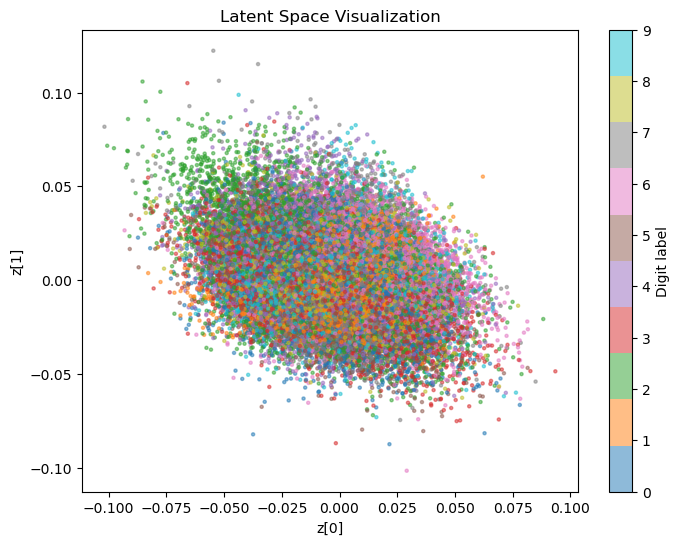

In [6]:
import matplotlib.pyplot as plt

# Visualize the latent space (first two dimensions)
z_all = []
y_all = []

for (batch, labels), _ in train_dataset:
    # Pass through encoder to get z_mean
    z_mean, _, _ = cvae.encoder.predict([batch, labels])
    z_all.append(z_mean)
    y_all.append(labels)

z_all = np.concatenate(z_all, axis=0)
y_all = np.argmax(np.concatenate(y_all, axis=0), axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', alpha=0.5, s=5)
plt.colorbar(label='Digit label')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.title('Latent Space Visualization')
plt.show()

In [7]:
#cvae.fit(train_dataset, epochs=10,batch_size=128)

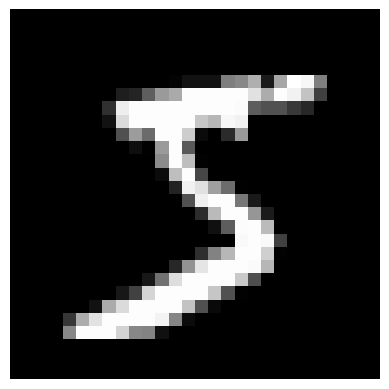

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 784)


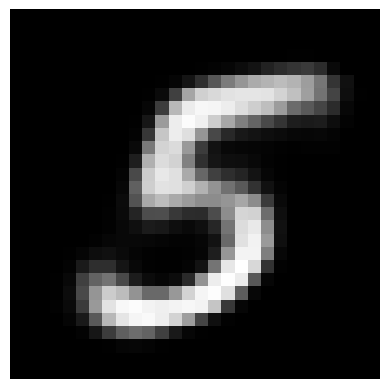

In [8]:
x_input = x_train[:1]         # 1 imagen (shape: (1, 28, 28))
cond_input = y_train[:1]      # su condición (shape: (1, 10))

plt.imshow(x_input[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input])

# Paso por el decoder para reconstrucción
reconstructed = cvae.decoder.predict([z, cond_input])
print(reconstructed.shape)
plt.imshow(reconstructed[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


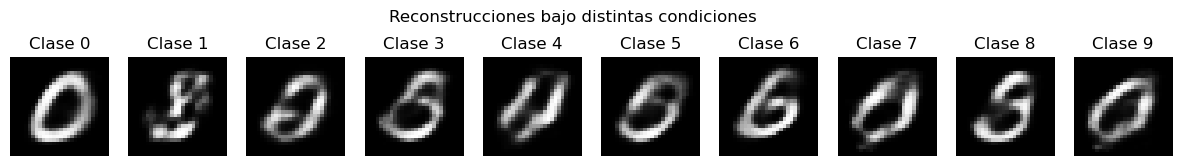

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


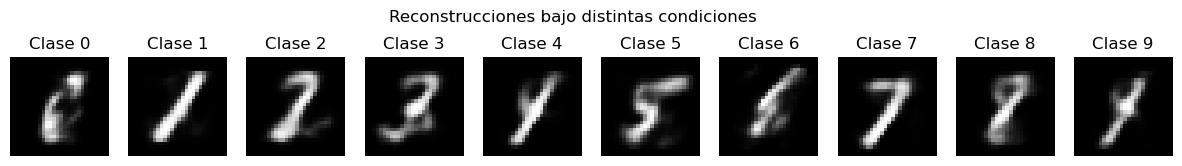

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


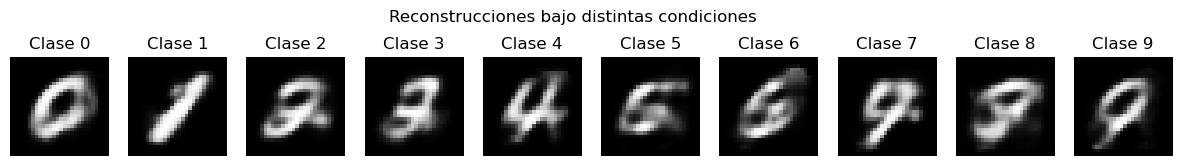

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


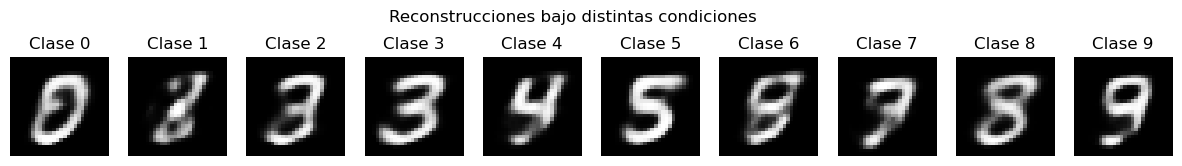

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


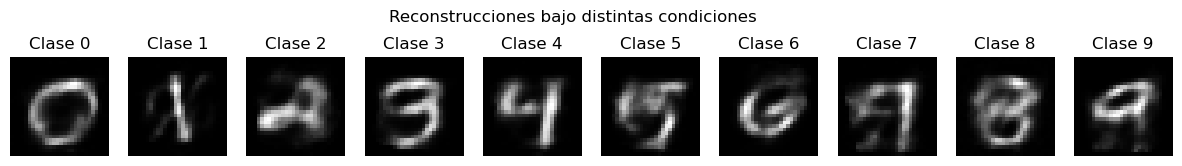

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


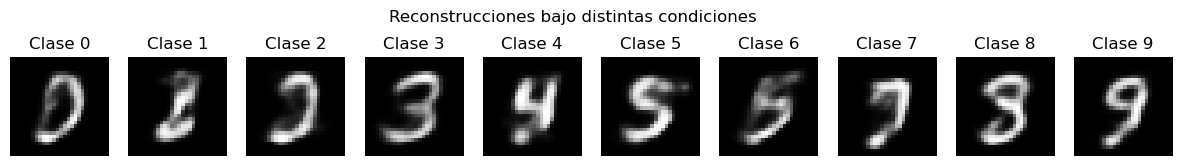

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


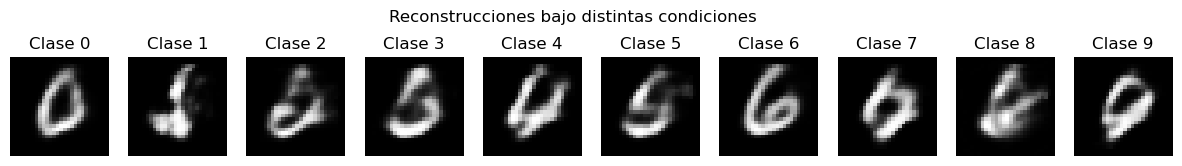

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


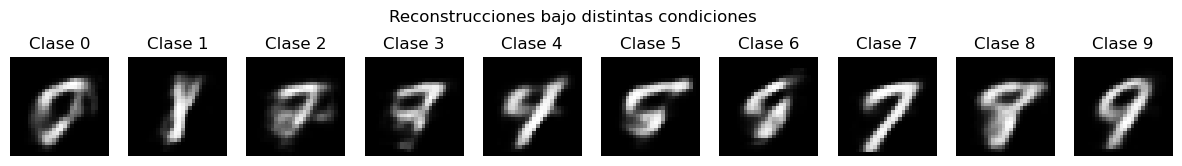

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


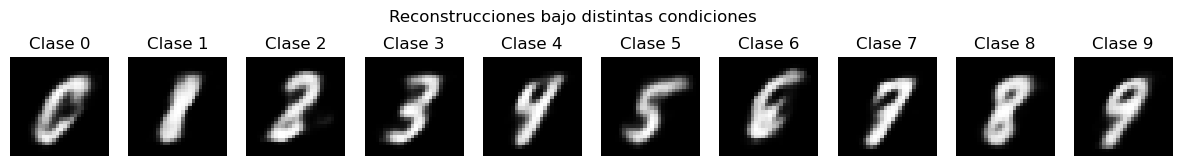

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


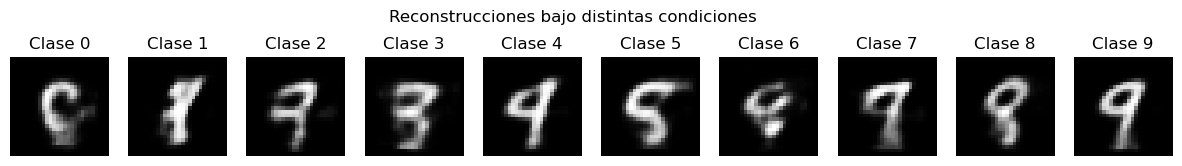

In [9]:
import visualizaciones.visualizar as vis

# Tomá una imagen del conjunto de test
indices_de_testeo=[1, 3, 5, 7, 2, 0, 13, 15, 17, 4] # inidices donde para que x_train[inidicies] sea 0 1 2 3 4 5 6 7 8 9 0

for i in indices_de_testeo:

    imagen = x_train[i]
    #plt.imshow(imagen)
    #plt.show()
    # Visualizá cómo se reconstruye con todas las condiciones posibles
    vis.condiciones(cvae, imagen)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


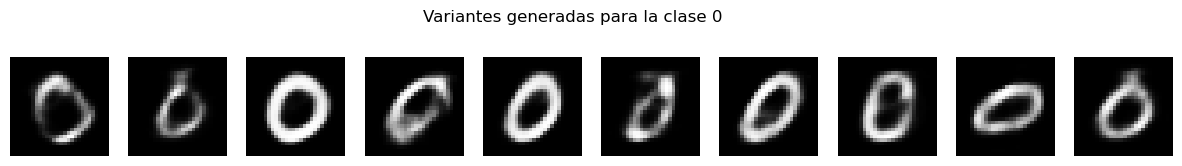

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


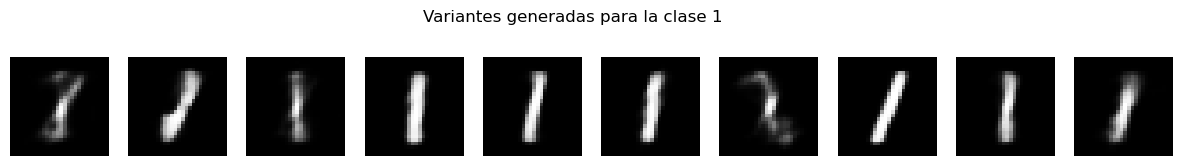

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


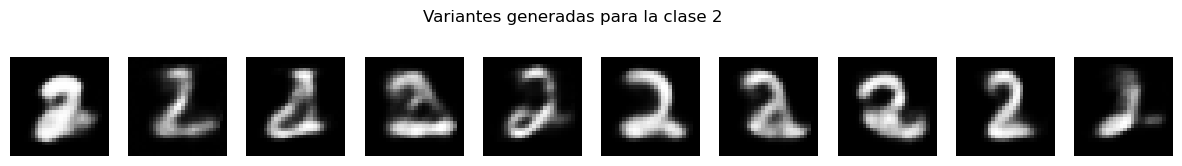

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


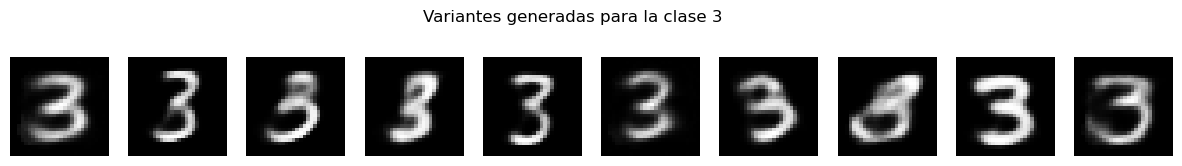

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


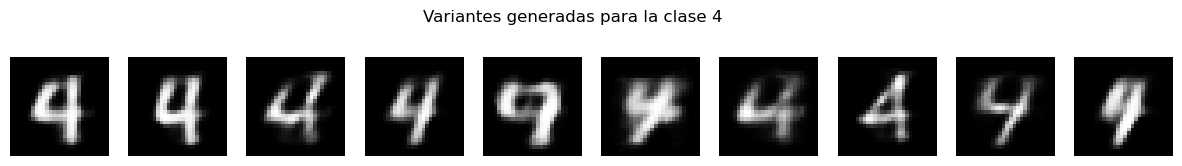

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


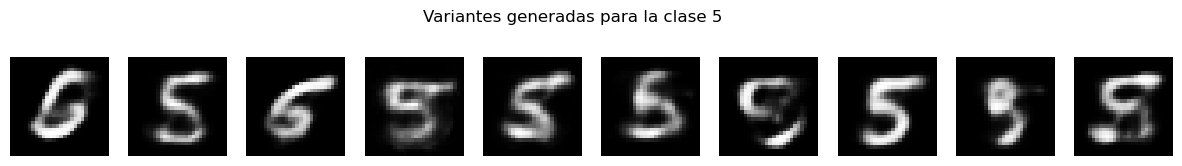

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


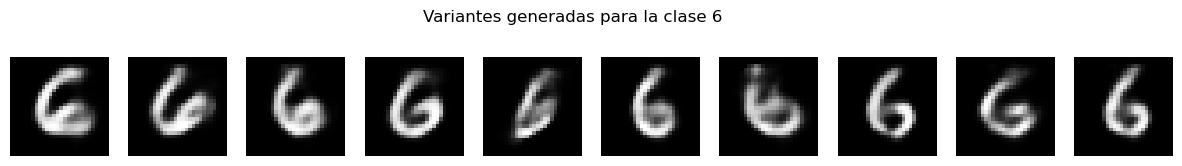

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


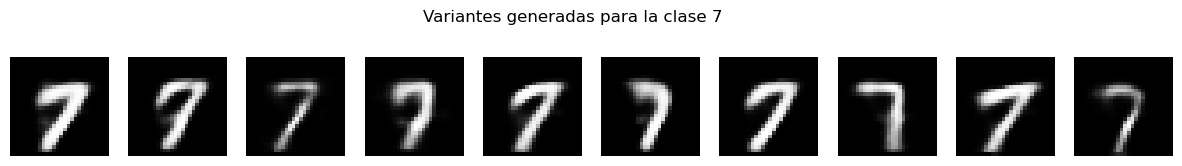

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


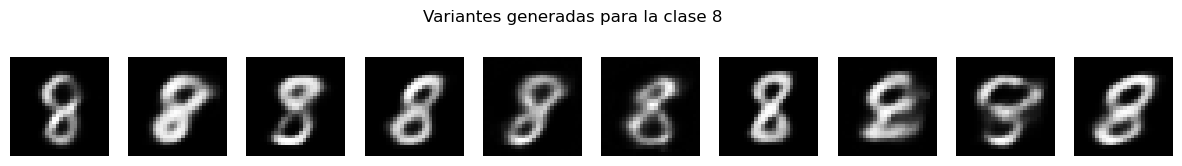

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


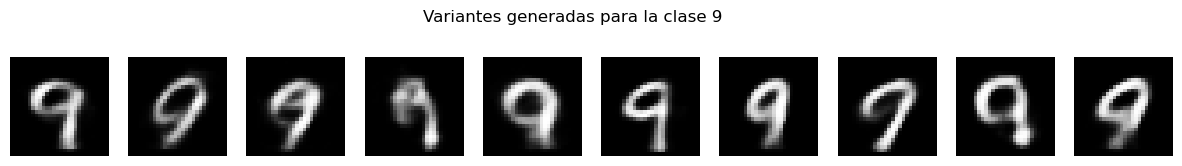

In [10]:
# Ver 10 variantes generadas para la clase 3
for i in range(10):
    
    vis.variantes(cvae, condicion_id=i, num_variantes=10)


# Predictores

In [11]:
import models.Predictor as predictores
importlib.reload(predictores)

predictor = predictores.build_predictor() 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

predictor.compile(optimizer, loss="categorical_crossentropy")

#x_rain_conv = np.reshape(x_train,(28,28,1)) 
predictor.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_data=(x_val, y_val)  # Include validation data
#    callbacks=[cp_callback_predictor_C2, early_stopping]  # Add early_stopping to callbacks
)

Model: "predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ original_input (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (ReshapeLayer)    │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,570 (197.54 KB)

 Trainable params: 50,378 (196.79 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.6349 - val_loss: 0.1689
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.1199 - val_loss: 0.0594
Epoch 3/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0862 - val_loss: 0.0475
Epoch 4/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0691 - val_loss: 0.0560
Epoch 5/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0636 - val_loss: 0.0485


(784,)


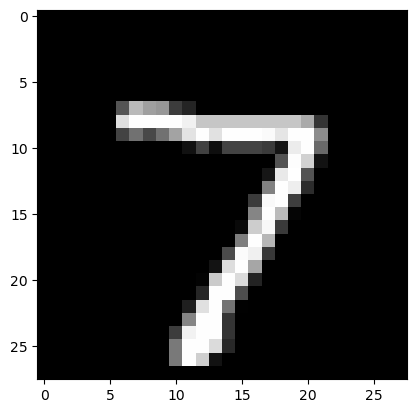

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Digito predicho: 7


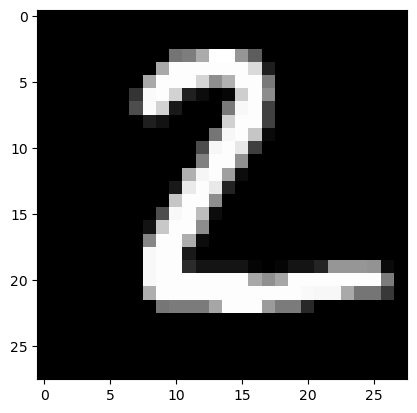

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Digito predicho: 2


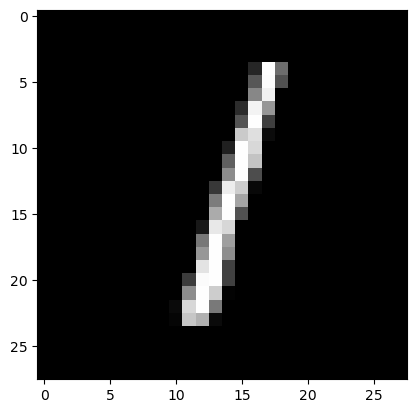

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Digito predicho: 1


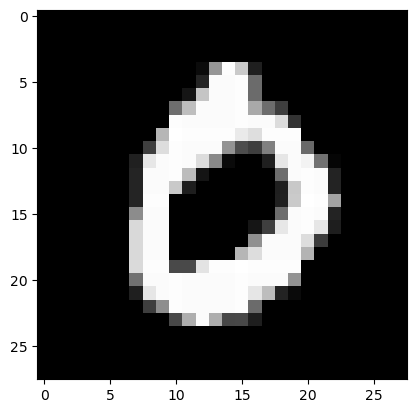

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Digito predicho: 0


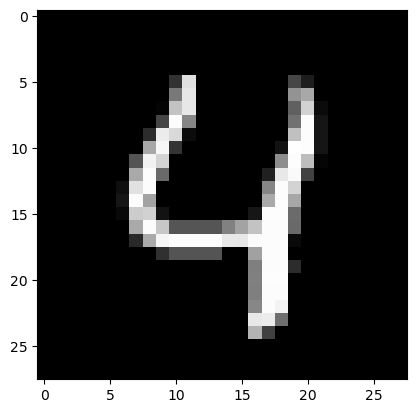

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Digito predicho: 4


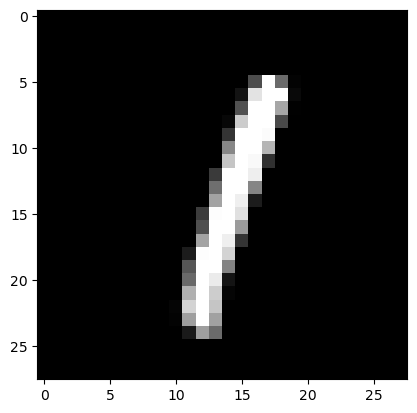

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Digito predicho: 1


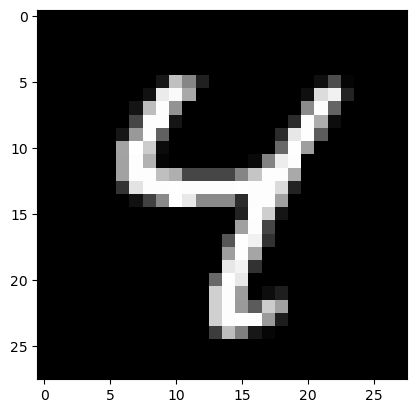

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Digito predicho: 4


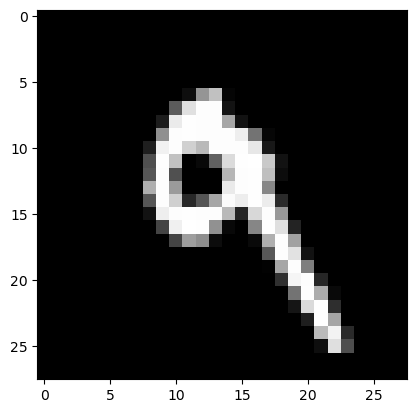

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Digito predicho: 9


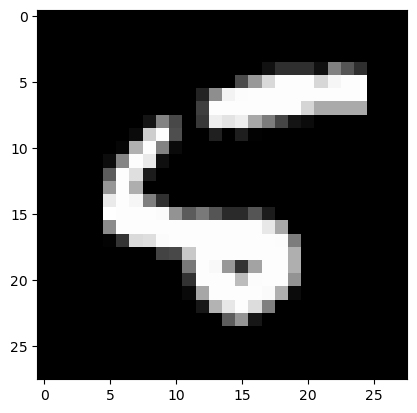

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Digito predicho: 5


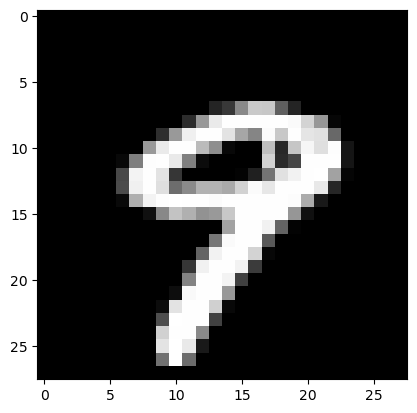

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Digito predicho: 9


In [12]:
print(x_test[0].shape)
for i in range(10):
    plt.imshow(x_test[i].reshape(28, 28),cmap="gray")
    plt.show()
    print("dentro del loop")
    print(x_test[i].shape)
    print(f"Digito predicho: {np.argmax( predictor.predict(x_test[i].reshape(1, 784)))}")

# Pruebas de separacion de digitos


Shape de x_train
(10, 784)
ITERACIÓN A:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
select_1:       tf.Tensor([1 1 1 1 1 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 0 0 0 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
################################################################################################
y_reduced:    tf.Tensor([5 0 4 1 9 2 1 3 1 4], shape=(10,), dtype=int64)
y_1_reduced:  tf.Tensor([1 3 9 4 1 2 3 7 9 9], shape=(10,), dtype=int64)
y_s1:          tf.Tensor([5 0 4 1 9 2 0 3 0 4], shape=(10,), dtype=int64)
y_1_s1:         tf.Tensor([0

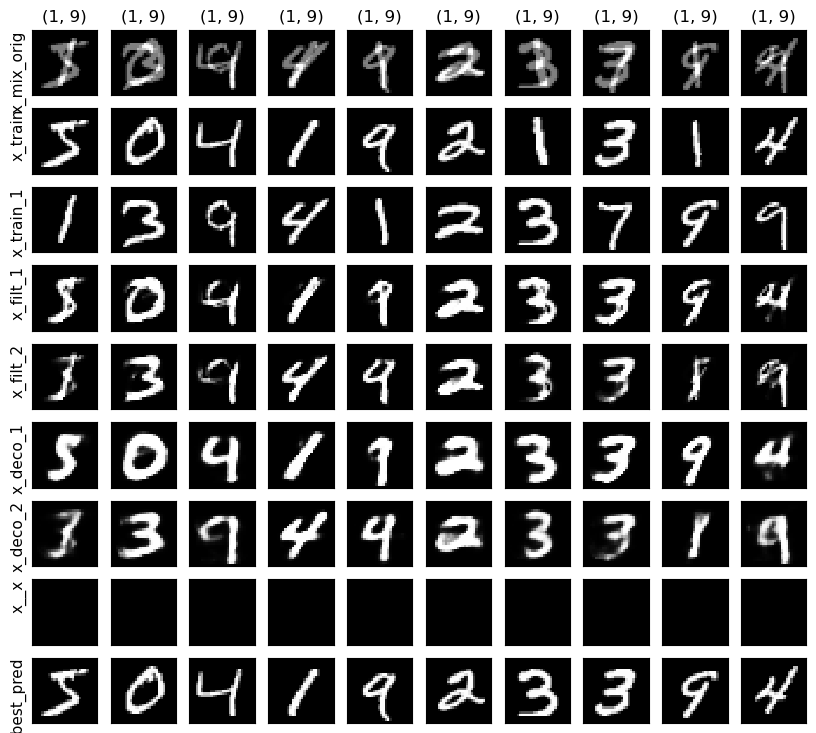

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
ITERACIÓN A:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
select_1:       tf.Tensor([1 1 0 1 0 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 1 0 1 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
################################################################################################
y_reduced

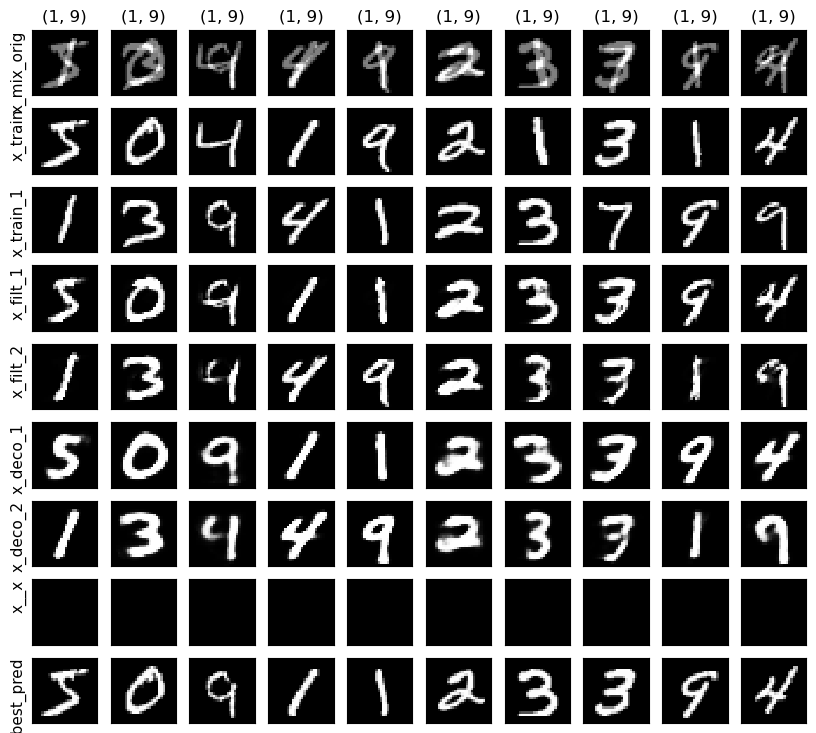

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
ITERACIÓN A:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
select_1:       tf.Tensor([1 1 0 1 0 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 1 0 1 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
################################################################################################
y_reduced

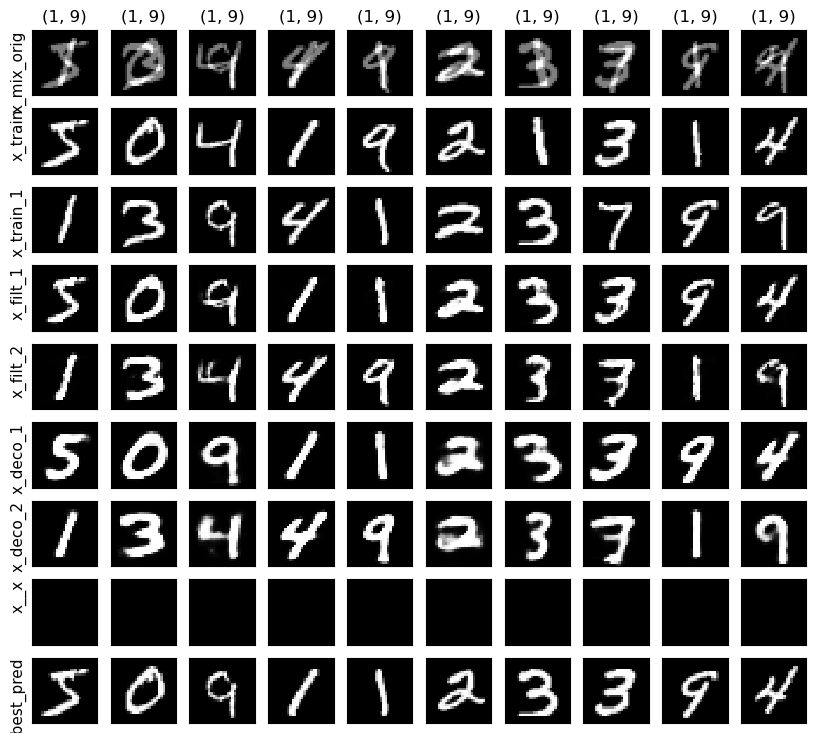

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
ITERACIÓN A:  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
select_1:       tf.Tensor([1 1 0 1 0 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 1 0 1 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
################################################################################################
y_reduced

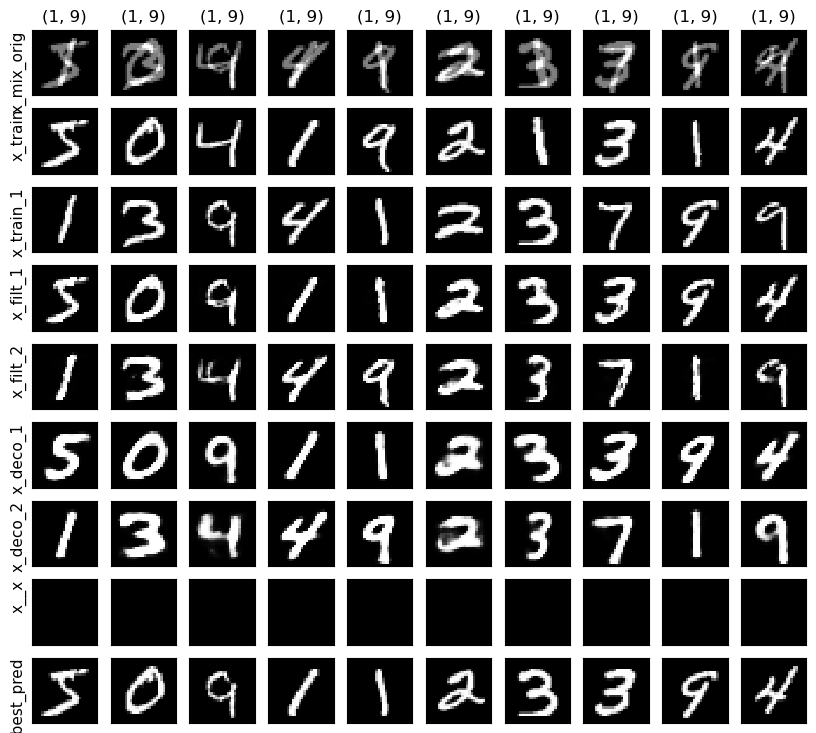

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
ITERACIÓN A:  4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
select_1:       tf.Tensor([1 1 0 1 0 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 1 0 1 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
################################################################################################
y_reduced

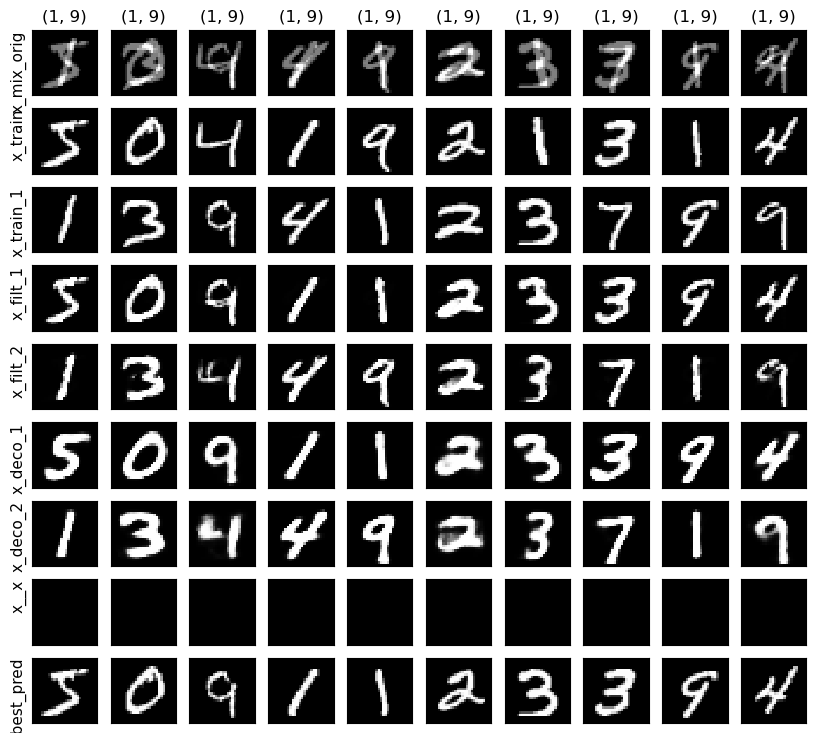

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.


In [13]:
import inferencias.inferencia as inf
import importlib
importlib.reload(inf)

inf.separar_digitos(x_train[0:10],x_train_1[0:10],y_train[0:10],y_train_1[0:10],en,de,predictor)